In [52]:
#needed to get rid of pandas data reader errors
#thanks https://stackoverflow.com/questions/68230237/python-pandas-datareader-and-yahoo-error-remotedataerror-unable-to-read-url
!pip install --upgrade pandas-datareader
#needed cus yahoo doesn't work anymore with DataReader
#Thanks https://stackoverflow.com/questions/74831853/pandas-datareader-yahoo-daily-not-working-suddenly

#Needed for MinMaxScaler
!pip install scikit-learn

!pip install yfinance

import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#verify dataReader ver
web.__version__ # Should show 0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'0.10.0'

In [53]:
#LOAD data

company = 'META'
start = '2012-01-01'
end ='2022-12-17'

my_data = yf.download(company, start, end, progress=False)

my_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2022-12-12,115.180000,115.720001,113.139999,114.709999,114.709999,24747100
2022-12-13,122.129997,123.300003,118.639999,120.150002,120.150002,44701100
2022-12-14,119.389999,124.139999,119.389999,121.589996,121.589996,36922000


In [54]:
#PREP data
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(my_data['Close'].values.reshape(-1,1))

prediction_days = 30

x_train = []
y_train = []

for  x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1 ))

In [55]:
# BUILD MODEL

model = Sequential()

# Specify the layers
# Create a layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
# Create a layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
# Create a layer
#Note: return_sequence MUST be set to False for last LSTM layer otherwise get this error
# if not allow_nd and array.ndim >= 3:
#   915             raise ValueError(
#   916                 Found array with dim %d. %s expected <= 2.
#   917                 % (array.ndim, estimator_name)
#Thanks https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1)) #Pred of next Closing value


In [56]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [57]:
#fit model
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
83/83 [==============================] - 24s 120ms/step - loss: 0.0154
Epoch 2/25
83/83 [==============================] - 4s 52ms/step - loss: 0.0028
Epoch 3/25
83/83 [==============================] - 5s 65ms/step - loss: 0.0025
Epoch 4/25
83/83 [==============================] - 4s 49ms/step - loss: 0.0023
Epoch 5/25
83/83 [==============================] - 4s 49ms/step - loss: 0.0023
Epoch 6/25
83/83 [==============================] - 5s 64ms/step - loss: 0.0022
Epoch 7/25
83/83 [==============================] - 4s 49ms/step - loss: 0.0023
Epoch 8/25
83/83 [==============================] - 4s 49ms/step - loss: 0.0021
Epoch 9/25
83/83 [==============================] - 5s 64ms/step - loss: 0.0018
Epoch 10/25
83/83 [==============================] - 4s 51ms/step - loss: 0.0017
Epoch 11/25
83/83 [==============================] - 4s 50ms/step - loss: 0.0017
Epoch 12/25
83/83 [==============================] - 5s 65ms/step - loss: 0.0019
Epoch 13/25
83/83 [================

In [58]:
#TEST MODEL

#Load Test Data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(company, start, end, progress=False)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((my_data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [59]:
#Make Predictions with test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

84/84 [==============================] - 2s 14ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

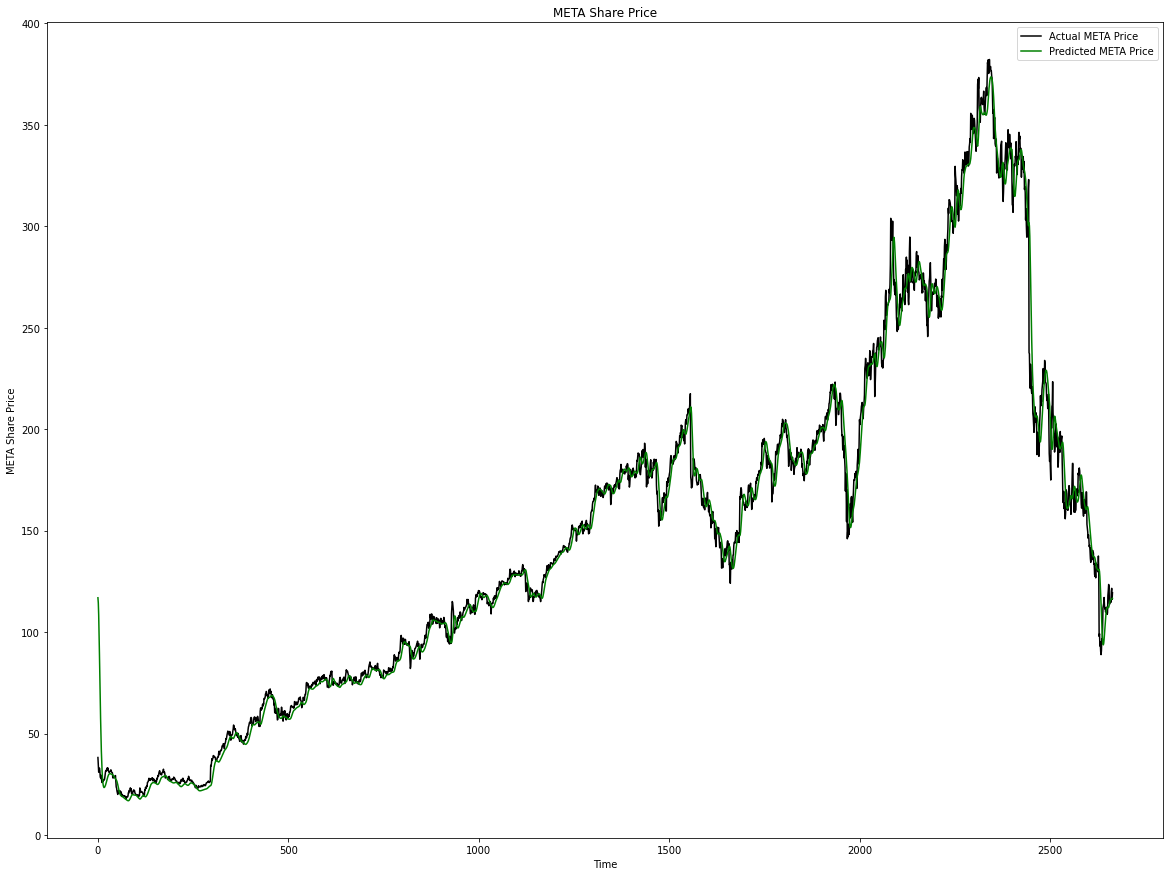

In [60]:
#PLOT test predictions

#Controls size of matplotlib plot box
plt.rcParams['figure.figsize'] = [20,15]

plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Price")

plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show



In [61]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 2s 2s/step
Prediction: [[117.01247]]
